# **BUSI488 / COMP488 Data Science in the Business World**
## *Spring 2023*  
Daniel M. Ringel

Kenan-Flagler Business School and UNC Department of Computer Science

*The University of North Carolina at Chapel Hill*  
dmr@unc.edu

## Class 25 - Main Notebook
## **Fine-Tuning Transformer Models for Text Classification**

![http://2.bp.blogspot.com/-E3Ub-2wizn4/Uh4EvB7YCdI/AAAAAAAAB9c/uymxk45PLVU/s1600/Danbo-leyendo.jpg](http://2.bp.blogspot.com/-E3Ub-2wizn4/Uh4EvB7YCdI/AAAAAAAAB9c/uymxk45PLVU/s1600/Danbo-leyendo.jpg "Transformer Models")

*April 20, 2023*  
Version 1.1


## Prep-Check:
- **Sentence Labeling Task:** Completed labeling 240 sentences using Qualtrics Link that was e-mailed to you.

- **Read before class:** Timoshenko, A. and Hauser, J.R., 2018. Identifying customer needs from user-generated content. Marketing Science, 38(1), pp. 1-20.

- **Progressed on Major Class Project:**
  - Started collecting and wrangling data
  - First descriptive insights
  - Rough storyline
-----

# IMPORTANT
***YOU MUST load this notebook in Google's Colab Environment***  
(or have a local computer with a GPU environment installed - which can be a bit tricky) 
- Use GPU as hardware accelerator: Menu > Runtime > Change Runtime Type >  Select GPU from drop-down in pop-up
- This will dramatically increase the encoding of text with advanced models such as BERT
- You have limited free GPU hours! 
- Make sure you change it back when we are done to "none" and terminate the session!

# This notebook has 4 parts 
  - **Part 1** Construct a sample from labeled data
  - **Part 2** Fine-tunes a pre-trained Transformer Model to classify sentences, evaluates model performance, and saves the fine-tuned model. 
  - **Part 3** Loads a fine-tuned model and uses it to classify new sentences
  - **Part 4** Where to from Here? Building a better Classifier (is not hard!)


# **Part 1** Construct a sample from labeled data

In [1]:
# 0. Load libraries
import numpy as np
import pandas as pd
import random

In [2]:
# 1. Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Navigate to the folder where the files for Class 25 are:
%cd /content/drive/MyDrive/488/Class25/Main/

# 3. See what is in the folder: Special shell command to view the files in the current directory of the notebook environment
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/488/Class25/Main
488-2023-Class25-Main.ipynb  TP_NotTP.json


## 1.1 Construct a Sample to build a Classifier on

- You responses from the labeling survey were pre-processes using the Bonus-Survey notebook: `488-2023-Class25-Survey.ipynb`
- We want a classifier that can tell whether a sentence is about toothpaste.
- We will eventually fine-tune a Transformer Model (DistillBERT) in Part 2 of this notebook for our classification task. However, you could also use Logistic Regression as we previously did in Class 24.

In [3]:
# 1. Read the previously saved toothpaste or not toothpaste json file
df = pd.read_json('TP_NotTP.json', orient ='split', compression = 'infer')

# 2. Get the positive and negative sentences from dataframe
pos_sen = list(df[df['label'] == 1]['sentence'])
neg_sen = list(df[df['label'] == 0]['sentence'])

In [4]:
# 3. Check Distribution of Classes
df.label.value_counts()

1    1317
0     898
Name: label, dtype: int64

## 1.2 Ensure a Balanced Sample
- We have 2 labels or "classes" in our data: 0 (negative) and 1 (postive).
- Notice how we have a lot more positive samples (i.e., sentences that are about the toothpaste we are looking for) than negative samples (sentences that are not about toothpaste).
- We would like to get a balanced sample so that our classifer needs to learn how to clearly differentate between positive and negative samples.

In [5]:
# 1. Check the size of sentences for each class
pos_len = len(pos_sen)
neg_len = len(neg_sen)

# 2. Get the minimum count for a balanced sample
min_cnt = min(len(pos_sen), len(neg_sen))
print(min_cnt)

898


In [6]:
# 3. There are more sentences belonging to class 1.
# We will randomly sample equal number of sentences from class 1.
# Sentences will be our feature variable (the one predictions are based on)
random.seed(0)
sentences =  random.sample(neg_sen, min_cnt) + random.sample(pos_sen, min_cnt)

# 4. Prepare the labels for classification
# Labels will be our response variable (what we are trying to predict)
labels = [0] * min_cnt + [1] * min_cnt

In [7]:
# 5. Let's double check that we have the same number of sentencs and labels
len(sentences), len(labels)

(1796, 1796)

In [8]:
# 6. Let's inspect the first couple of sentences (should be positive samples) and last couple of sentences (should be negative samples)
print(f'Negative Samples: \n')
print(*sentences[0:5],sep='\n')
print(f'\nPositive Samples: \n')
print(*sentences[-6:-1],sep='\n')

Negative Samples: 

The medium bristles are ok, but softer would irritate gums less; however, they do clean your teeth thoroughly.
Nice tooth brush with soft bristles for sensitive gums
This is one of the best mouthwashes to use to get white teeth.
Much softer and more comfortable against my gumline, much less irritation, and a faster clean that actually seems *better* than the electric toothbrushes I've tried.
I do not have gum issues or Tender gums and this fried my lower gums even with how meticulously careful I was putting it on my teeth

Positive Samples: 

Way better than whitening strips.
Fresh taste and long lasting fresh breath
My teeth feel so clean and look much whiter.
Been using for 3 months and I can see a difference in whiteness.
""sensodyne, i can taste my breath after, it just ain't fresh""


In [9]:
# 7. Save Balanced Toothpaste/Not toothpaste Sample
df=pd.DataFrame(
    {'sentences': sentences,
     'labels': labels})

df.to_pickle('TP_NotTPSampleBalanced.pkl')

# **Part 2** Fine-Tune a pre-trained Large Language Model
- We will use DistilBERT, a more compact version of the original BERT model

To work with DistilBERT we need two great packages:

**huggingface Transformers** 
*State-of-the-art Natural Language Processing for TensorFlow and PyTorch*
https://transformer.huggingface.co/

**PyTorch** 
*An open source machine learning framework that accelerates the path from research prototyping to production deployment*
https://pytorch.org/

![Transformers](https://venturebeat.com/wp-content/uploads/2019/09/hugging-face.png?fit=750%2C375&strip=all "Transformers")



In [10]:
# 1. We will need to install huggingface transformers first
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# 2. Load other required models
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

## 2.1 Load Pre-Trained Large Language Model: DistilBERT
- We will use ``distilbert-base-cased`` model for fine-tuning because it runs faster than BERT (which is important given the time we have in the classroom).
- There are other pre-trained models like ``xlnet``, ``BERT``, ``deberta``, ``BERTweet``,  etc.
- The full list of models can be found at https://huggingface.co/models
- To use other models, just change the variable ``model_name``

In [12]:
# 1a. For DistilBERT:
model_name = 'distilbert-base-cased'

# 1b. For BERT:
#model_name = 'bert-base-cased'

# 2. Import tokenizer and model imports from huggingface
from transformers import AutoTokenizer, AutoModel

# 3. Load pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

## 2.2 Load Balanced Sample and Split data for Training and Testing
- Load our previously saved Balanced Sample (sentences with 50% positive and 50% negative labels)
- We will use ``train_test_split`` from sklearn to split the data for training and testing.
  - 80% of the data is used for training and 20% for testing
  - We stratify the sample by label: Why?
  - We will seed the random state to 42: What is the effect of doing so?

In [13]:
# 1. Load the data!!
df=pd.read_pickle("TP_NotTPSampleBalanced.pkl")
df.head()

,sentences,labels
0,"The medium bristles are ok, but softer would i...",0
1,Nice tooth brush with soft bristles for sensit...,0
2,This is one of the best mouthwashes to use to ...,0
3,Much softer and more comfortable against my gu...,0
4,I do not have gum issues or Tender gums and th...,0


In [14]:
# 2. Extract Sentences (Xs) and Labels (ys)
sentences=df.sentences.to_list()
labels=df.labels.to_list()

In [15]:
# 3. Load train_test_split from sklearn and split the Sample into training and testing data
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences,labels,test_size=0.2, stratify=labels, random_state=42)
print(f'Training Sample contains {len(train_sentences)} sentences\nTesting Sample contains {len(test_sentences)} sentences.')

Training Sample contains 1436 sentences
Testing Sample contains 360 sentences.


## 2.3 Convert data for fine-tuning DistilBERT. 
We apply the following:
- Tokenization
- Padding
- Masking

Fortunately, there is a function called ``encode_plus`` that does all 3 tasks for us.  

In [16]:
# 1. Set the maximum length value
padding_type = 'max_length'

# 2. Restrict to maximum length 75 to save RAM memory
# Note: Use the same 'max_length' in training and testing.
# You can change this length depending on GPU RAM.
# If you are using greater lengths, use lower batch sizes (eg: 8, 16)
# Change the variable per_device_train_batch_size in 1.11 Training Arguments function.
max_length = 75

In [17]:
# 3. Function to tokenize the sentences and return tokens and padding
def tokenize_sentences(sent):
  input_ids = []
  attention_mask = []
  token_ids = []

  for i in tqdm(range(len(sent))):
    sentence = sent[i]
    encoded = tokenizer.encode_plus(text=sentence,
                                    add_special_tokens=True,
                                    padding=padding_type,
                                    max_length=max_length,
                                    truncation=True,
                                    return_token_type_ids=True,
                                    return_tensors='pt')

    input_ids.append(encoded['input_ids'])
    attention_mask.append(encoded['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0, out=None)
  attention_mask = torch.cat(attention_mask, dim=0, out=None)

  return input_ids, attention_mask

In [18]:
# 4. Convert training data
train_input_ids, train_attention_mask = tokenize_sentences(train_sentences)
test_input_ids, test_attention_mask = tokenize_sentences(test_sentences)

100%|██████████| 360/360 [00:00<00:00, 4739.68it/s]


## 2.4 Turn Labels into a Tensor
- A ``Tensor`` is similar to a numpy array.
- However, with numpy arrays computation on GPUs is not straightforward.
- You may need specialized data arrays to convert numpy array into GPU executable form.
- ``Tensor`` makes this job easier with smooth data migration among ``cpu``, ``gpu`` and ``local memory``.
- ``LongTensor`` is similar to ``int`` in programming languages. It handles integer tensors.

In [19]:
# 1. Convert labels to tensor (PyTorch's array) for training
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

In [20]:
# 2. Let's see the shape of our inputs
print(f"Tokenized inputs shape: {tuple(train_input_ids.size())}")
print(f"Attention mask shape: {tuple(train_input_ids.size())}")

Tokenized inputs shape: (1436, 75)
Attention mask shape: (1436, 75)


## 2.5 Create a Data Loader

When training on GPUs, retreiving batches of data swiftly is important for less overhead and more parallel computation.



In [21]:
# 1. Class to retrieve batches efficiently for GPU computation

class TaskDataset(torch.utils.data.Dataset):
  def __init__(self, inputids, attnmasks, labels):
    self.inputids = inputids
    self.attnmasks = attnmasks
    self.labels = labels

  def __getitem__(self, idx):
    item = {}
    item['input_ids'] = self.inputids[idx]
    item['attention_mask'] = self.attnmasks[idx]
    item['labels'] = self.labels[idx]
    return item

  def __len__(self):
    return len(self.labels)

In [22]:
# 2. Convert training data into data loader object
train_loader = TaskDataset(train_input_ids, train_attention_mask, train_labels)

# 3. Convert test data into data loader object
test_loader = TaskDataset(test_input_ids, test_attention_mask, test_labels)

## 2.6 Model Evaluation Metrics
- We will evaluate model performance with accuracy and f1 score
- We also want to examine recall and precision

In [23]:
# 0. Import libraries
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from scipy.special import softmax

# 1. Function to compute precision, recall, f1 and accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    pred_scores = softmax(pred.predictions, 1)
    pred_scores = np.max(pred_scores, 1)
    if(numclasses > 2):
        avg = 'macro'
    else:
        avg = 'binary'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=avg)
    acc = accuracy_score(labels, preds) * 100
    return {
        'accuracy': acc,
        'f1': f1 * 100,
        'precision': precision,
        'recall': recall,
        'pred_scores': pred_scores,
        'pred_indices': preds
    }

## 2.7 Instantiate Classification Model

- Our model has a DistilBERT layer followed by classification layer
- In the final classification layer we get 2 outputs for each of the classes

In [24]:
# 1. Import methods from hugging face
from transformers import AutoModelForSequenceClassification

# 2. Let's first define the number of classes in our dataset: in classifcation we have 2 classes (0 and 1)
numclasses = 2

# 3. Instantiate the model
model = AutoModelForSequenceClassification.from_pretrained(
		model_name,
		output_hidden_states=False,
		output_attentions=False,
		num_labels=numclasses
		)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier

## 2.8 Set Training parameters
- Before training, we need to define couple of things.
- We will mention all the hyper-parameters of our model using ``Trainer``. This helps us avoid loops and iterating over batches.



In [25]:
# 1. Hyper-parameters for our model
numepochs = 5

# 2. Mention large number to avoid saving models (They are huge!)
logging_steps = 10000000
save_steps = 1000000

In [53]:
# 3. Import TrainingArguments from huggingface
from transformers import TrainingArguments

# 4. per_device_train_batch_size is the batch size we use during training.
# If you are facing RAM issues in the colab, change this value to 8 or 16.
training_args = TrainingArguments(
		output_dir=' ',
		num_train_epochs=numepochs,
		warmup_steps=1000,
		weight_decay=0.01, 
    per_device_train_batch_size=32, # Change this value if you have RAM issue in colab # Can go up to 64, but if its crashing go down to 16
		logging_dir=' ',
		logging_steps=logging_steps,
		save_steps=save_steps
		)

## 2.9 And Now Fine-Tuning!
We have all the ingredients to fine-tune the pre-trained (DistilBERT) model to our classification task.
- Fine-tuing a transfomer for a classifcation task takes a lot longer than fitting a logistic regression to feature vectors (e.g., SBERT vectors from text as we did in Class 24)
- We hope for much better accuracy to make it work the computational expense!

In [27]:
%%time
# 1. Import trainer from huggingface
from transformers import Trainer

# 2. Load the trainer class from huggingface
trainer = Trainer(
		model=model,
		args=training_args,
		train_dataset=train_loader,
		eval_dataset=test_loader,
		compute_metrics=compute_metrics
		)

# 3. Fine-Tune the Model
trainer.train()

Step,Training Loss


CPU times: user 36.2 s, sys: 1.75 s, total: 37.9 s
Wall time: 51.1 s


TrainOutput(global_step=225, training_loss=0.49220384385850696, metrics={'train_runtime': 45.8366, 'train_samples_per_second': 156.643, 'train_steps_per_second': 4.909, 'total_flos': 139323621438000.0, 'train_loss': 0.49220384385850696, 'epoch': 5.0})

## 2.10 Save Fine-Tuned Model
- To save the model, we use ``output_dir`` variable.   
- Feel free to change this variable.   
- But remember this path to re-load the model again.
- You can also share your model with others (but you should give them the code to run it as well!). 

In [28]:
# 1. Path to save the model
# If you want to use another directory, change here.
output_dir = 'model_TP/'

# 2. Save the model to output_dir
trainer.save_model(output_dir)

## 2.11 Evaluate Fine-Tuned Model on the Test Data
We fine-tuned DistilBERT to classify clean topic sentences. Let's see how well our fine-tuned model does!

In [29]:
# 1. Evaluates the model on test data
testscores = trainer.evaluate()

Trainer is attempting to log a value of "[0.8311322  0.8630988  0.9442727  0.9711854  0.98396933 0.9746241
 0.96256083 0.96404916 0.81413066 0.93143725 0.94307154 0.98402864
 0.98598087 0.9755111  0.95486355 0.7679155  0.57775605 0.96994543
 0.96849424 0.96366507 0.93630654 0.98253375 0.97428334 0.974621
 0.6496218  0.98059225 0.96359754 0.9853232  0.97696984 0.9832833
 0.98566324 0.97845274 0.97896326 0.6149     0.983976   0.9057232
 0.9790851  0.975878   0.600652   0.9740199  0.9802271  0.9625786
 0.64938223 0.96630436 0.96424794 0.76562256 0.9770551  0.984917
 0.9823338  0.9498867  0.95781314 0.9461401  0.9430411  0.9731088
 0.9742518  0.93011326 0.97854257 0.9641125  0.78496724 0.9852068
 0.9837608  0.74310106 0.67679    0.93970484 0.9556656  0.77609813
 0.9159234  0.9308412  0.9643048  0.98015255 0.909096   0.93522865
 0.74879223 0.5742154  0.9376384  0.952826   0.98335373 0.8346785
 0.9751745  0.9465816  0.983508   0.9813265  0.9854767  0.7269627
 0.9626662  0.97879225 0.97774005

In [30]:
# 2. Print accuracy score and f1 score
print(f"Test Accuracy {testscores['eval_accuracy']:.2f}")
print(f"Test F1 Score {testscores['eval_f1']:.2f}")

Test Accuracy 90.00
Test F1 Score 90.53


## 2.12 Check the Classifcation Report

In [31]:
# 1. Get the predictions from trainer
test_pred_labels = testscores['eval_pred_indices']
test_pred_scores = testscores['eval_pred_scores']

In [32]:
# 2. Import required package
from sklearn.metrics import classification_report

# 3. Output Classifcation Report
print(classification_report(test_labels, test_pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       180
           1       0.86      0.96      0.91       180

    accuracy                           0.90       360
   macro avg       0.91      0.90      0.90       360
weighted avg       0.91      0.90      0.90       360



## 2.13 Check the Confusion Matrix

Text(0.5, 23.52222222222222, 'Predicted')

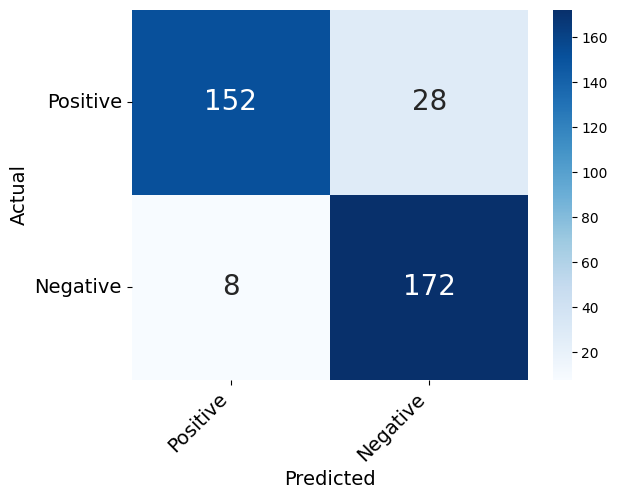

In [33]:
# 1. Load required packages
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 2. Plot the confusion matrix
con_matrix = confusion_matrix(test_labels, test_pred_labels)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Positive', 'Negative'), ('Positive', 'Negative'))

# 3. Visualize
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
bottom, top = heatmap.get_ylim()
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

In [34]:
## Create a dataframe to store sentences and labels for each topic.
df = pd.DataFrame({'sentences': test_sentences, 
                   'predicted_labels': test_pred_labels,
                   'test_labels': test_labels,
                   'predicted_scores': test_pred_scores,
                   })

# Let's look at our dataframe.
pd.set_option('max_colwidth', 300) # make sure we can see all the sentences
df

,sentences,predicted_labels,test_labels,predicted_scores
0,I donÃ¢â¬â¢t like stink breath and Colgate can secure that for you,1,1,0.831132
1,"It works as intended, kills germs / """"freshens"""" breath.",1,1,0.863099
2,"I am not a fan of white strips either, but at least that feels like itâs doing more than this stuff does.",0,0,0.944273
3,Cleans teeth and freshens breath.,1,1,0.971185
4,"I find a lot of toothpastes, especially those that whiten, to have too strong of a flavor.",1,1,0.983969
...,...,...,...,...
355,This has helped my gums and roof of mouth heal.,0,0,0.900796
356,Really great whitening for my 60+ year old teeth.,1,0,0.956690
357,Optic white toothpaste usually whitens very quickly.,1,1,0.984469
358,I have been using the Colgate whitening toothpastes for years.,1,1,0.983331


## 2.14 Check where our Classifier failed

In [35]:
# 1. Let's see where our classifier was wrong.
df[df.predicted_labels!=df.test_labels]

,sentences,predicted_labels,test_labels,predicted_scores
16,I've used Crest 3D whitening for over a year and it takes care of those coffee and red wine stains.,1,0,0.577756
33,"It breathes in, and begins to say what sounds like """"Lok...""""",1,0,0.614900
73,"No cavities still, so they must work well.",1,0,0.574215
94,You can feel it work on your gums after brushing.,0,1,0.942748
104,You can see the fresh breathe strips in the gel.,0,1,0.967254
118,"My regular cleaning isn't due for a few months, but I have no reason to think I have any new cavities.",1,0,0.732491
119,I really like how well this works and how gentle it is on my teeth and gums.,0,1,0.702928
120,"I have sensitive teeth, so I was worried about whitening them, but there was no pain with this product.",1,0,0.961310
129,I didnât like the way it felt on my teeth it felt yucky to me it did whiten my teeth some itâs simple to use .,0,1,0.651840
154,They are great when you need to freshen your breath.,1,0,0.774919


In [36]:
# 2. Let's see where our classifier was most uncertain
df[df.predicted_scores<.8]

,sentences,predicted_labels,test_labels,predicted_scores
15,It allows you to focus on teeth that are less white than others.,0,0,0.767915
16,I've used Crest 3D whitening for over a year and it takes care of those coffee and red wine stains.,1,0,0.577756
24,This product hands down best bang for your buck for whiten your teeth.,1,1,0.649622
33,"It breathes in, and begins to say what sounds like """"Lok...""""",1,0,0.614900
38,The color is slightly off white being more gray than black.,1,1,0.600652
42,My teeth and gums feel cleaner as well.,1,1,0.649382
45,Since using this product I have noticed that my gums are so much better.,1,1,0.765623
58,Had bleeding and receding gums FROM SONICARE!,0,0,0.784967
61,"""""I-"""" He pauses, taking a deep breath.",0,0,0.743101
62,"My teeth don't seem to be any whiter than they were before, but after a bit of usage I do like the style of the head and the handle.",0,0,0.676790


In [58]:
# 2. Let's see where our classifier was most uncertain
df[(df.predicted_scores<.8) & df.predicted_labels!=df.test_labels]

AttributeError: ignored

#### **Discussion Point**
What might be a bigger problem?
1. Misclassifed sentences with high certaininty (i.e., high predicted scores)
2. Correctly classified sentences with low certainty (i.e., low predicted scores)

What can you do to mitigate the problem(s)?

## 2.15 Improving Classification Performance

We can still improve the performance of our Classifier!
Change these hyper-paramaters:
- max_length
- num_epochs

## ***DO NOT FORGET TO TERMINATE YOUR GPU SESSION***  
- Remove GPU as hardware accelerator: Menu > Runtime > Change Runtime Type >  Select NONE from drop-down in pop-up
- You have limited free GPU hours! 
- Make sure you change it back when we are done to "None" and terminate the session!

# **Part 3** Classify New Sentences with our Fine-Tuned Transformer Model
- A fine-tuned model is only useful when we can use it to rapidly classify many, many new sentences.

1. Load the saved fine-tuned model
2. Use it to classify new sentences

# IMPORTANT
***YOU MUST load this notebook to Google's Colab Environment***  
(or have a local computer with a GPU environment installed - which can be a bit tricky) 
- Use GPU as hardware accelerator: Menu > Runtime > Change Runtime Type >  Select GPU from drop-down in pop-up
- This will dramatically increase the encoding of text with advanced models such as BERT
- You have limited free GPU hours! 
- Make sure you change it back when we are done to "none" and terminate the session!

## 3.1 Prerequisites

In [59]:
# 1. We will need to install huggingface transformers first
#!pip install transformers #already done in this full notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# 2. Install pickle5 on CoLab - sometimes pkl files and models may be saved in a newer pickle format.
#!pip install pickle5

In [39]:
# 3. Load other required models
from tqdm import tqdm
#import pickle5 as pickle
import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [40]:
# 4. Connect your Google Drive  - Already done in this notebook
#from google.colab import drive
#drive.mount('/content/drive')

# 5. Navigate to the folder where the files for Class 25 are:
#%cd /content/drive/MyDrive/BUSI488/Class25/

# 6. See what is in the folder: Special shell command to view the files in the current directory of the notebook environment
!ls

' '			       model_TP        TP_NotTPSampleBalanced.pkl
 488-2023-Class25-Main.ipynb   TP_NotTP.json


## 3.2 New Sentences
- I defined several sentences in a list of strings
- You are welcome to add your own sentences! 

In [60]:
New_Sentences = ["My teeth have been the same color most of my life and no toothpaste has ever been effective in whitening them.",
    "My son and I current both agree that Optic White is our everyday fave for whitening.",
    "Cleans teeth and breath.",
    "After a couple of months I realize the gum restore toothpaste doesn't have enough benefits for the hassle.",
    "When I have a special occasion and want to brighten my smile, I use a whitening toothpaste and stay away from things that stain the teeth like red wine, coffee, tea, mustard.",
    "Works well to remove tarter and bad breath .",
    "Data Science in the Business World.",
    "Hard to squeeze and then it exploded",
    "Broke a tooth playing football.",
    "Colgate scored big in last night's game!",
    "Lot's of bleeding going on with that Crest.",
    "I hate unicorns",
    "Shaq dunks on ya teeth",
    "You cannot breath without it stanking",
    "A te chilla la ardilla"]

## 3.3 Load our Fine-tuned DistilBERT model

- Here, we will load the fine-tuned and saved model.
- You would have saved model during training using ``output_dir`` variable.
- We will use the same path to load the model again.
- **IMPORTANT**: You need to specify the same model that you fine-tuned for ```model_name``` 



In [61]:
# 1. Change the path where you saved the trained model.
output_dir = 'model_TP/'

# 2. Import tokenizer and model imports from huggingface
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 3. Note. If you have different model (eg: BERT) during training change the appropriate name here.
model_name = 'distilbert-base-cased'
#model_name = 'bert-base-cased'

# 4. Load pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 5. Let's first set the number of classes in our dataset
numclasses = 2

# 6. Instatiate the model
model = AutoModelForSequenceClassification.from_pretrained(
		output_dir,
		output_hidden_states=False,
		output_attentions=False,
		num_labels=numclasses
		)

## 3.4 Prepare our New Sentences for Classification
- Tokenization
- Padding
- Masking
Again, we can use a function called ``encode_plus`` that does all the 3 tasks for us.

In [62]:
# 1. Set the maximum length value
padding_type = 'max_length'

# 2. Restrict to maximum length 75 to save RAM memory
# Note: Use the same 'max_length' in training and testing.
max_length = 75

In [63]:
# 3. Function to tokenize the sentences and return tokens and padding
def tokenize_sentences(sent):
  input_ids = []
  attention_mask = []
  token_ids = []

  for i in tqdm(range(len(sent))):
    sentence = sent[i]
    encoded = tokenizer.encode_plus(text=sentence,
                                    add_special_tokens=True,
                                    padding=padding_type,
                                    max_length=max_length,
                                    truncation=True,
                                    return_token_type_ids=True,
                                    return_tensors='pt')

    input_ids.append(encoded['input_ids'])
    attention_mask.append(encoded['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0, out=None)
  attention_mask = torch.cat(attention_mask, dim=0, out=None)

  return input_ids, attention_mask

In [64]:
# 4. Prepare New Sentences
test_input_ids, test_attention_mask = tokenize_sentences(New_Sentences)

100%|██████████| 15/15 [00:00<00:00, 2535.65it/s]


## 3.5 Convert New Sentence Data into a Data Loader Object

- When training on GPUs, retreiving batches of data swiftly is important for less overhead and more parallel computation.



In [65]:
# 1. Load utilities from pytorch
from torch.utils.data import TensorDataset, DataLoader

# 2. Convert data in correct formats
test_array = TensorDataset(test_input_ids, test_attention_mask)
test_loader = DataLoader(test_array, batch_size=8)

## 3.6 Initialize Model with Parameters
- We don't train the model here
- We use our fine-tuned model to classify new sentences
- But first, we need to initialize it


In [66]:
# 1. Import TrainingArguments from huggingface
from transformers import TrainingArguments, Trainer

# 2. Define the training args
training_args = TrainingArguments(
		output_dir=' ',
		logging_dir=' ',
		)

# 3. Load the trainer class from huggingface
# We will set train_dataset and eval_dataset to test_loader
trainer = Trainer(
		model=model,
		args=training_args,
		train_dataset=test_loader,
		eval_dataset=test_loader
		)

## 3.7 Classify New Sentences

In [67]:
%%time
# 1. Set the model to evalution mode
model.eval()

# 2. Use GPU as primary device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. Store the list of predictions
test_pred_labels = []
test_pred_scores = []
with torch.no_grad():
    for input_ids, attn_mask in test_loader:
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        outputs = model(input_ids, attn_mask)
        outputs = outputs['logits']
        test_pred_labels.extend(torch.argmax(outputs, 1).cpu().detach().numpy().tolist())
        test_pred_scores.extend(torch.max(torch.softmax(outputs, 1), 1)[0].cpu().detach().numpy().tolist())

CPU times: user 51.1 ms, sys: 973 µs, total: 52.1 ms
Wall time: 54.1 ms


In [68]:
# 4. Create a dataframe to store sentences and predicted labels
df = pd.DataFrame({'sentences': New_Sentences, 
                   'predicted_labels': test_pred_labels,
                   'predicted_scores': test_pred_scores
                   })

## 3.8 Check Our Classifier's Predictions!

It's a good idea to check a model's predictions for face-validity.

In [69]:
# 1. Let's see what our fine-tuned model classified as positive samples
pd.set_option('max_colwidth', 300) # make sure we can see all the sentences
display(df[df.predicted_labels==1].sort_values(by=['predicted_scores']))

,sentences,predicted_labels,predicted_scores
5,Works well to remove tarter and bad breath .,1,0.872362
1,My son and I current both agree that Optic White is our everyday fave for whitening.,1,0.885064
2,Cleans teeth and breath.,1,0.957042
4,"When I have a special occasion and want to brighten my smile, I use a whitening toothpaste and stay away from things that stain the teeth like red wine, coffee, tea, mustard.",1,0.974020
3,After a couple of months I realize the gum restore toothpaste doesn't have enough benefits for the hassle.,1,0.981384
0,My teeth have been the same color most of my life and no toothpaste has ever been effective in whitening them.,1,0.982344


In [70]:
# 2. Let's see what our fine-tuned model classified as negative samples
pd.set_option('max_colwidth', 300) # make sure we can see all the sentences
display(df[df.predicted_labels==0].sort_values(by=['predicted_scores']))

,sentences,predicted_labels,predicted_scores
14,A te chilla la ardilla,0,0.562256
6,Data Science in the Business World.,0,0.625627
10,Lot's of bleeding going on with that Crest.,0,0.730975
13,You cannot breath without it stanking,0,0.759623
9,Colgate scored big in last night's game!,0,0.772415
8,Broke a tooth playing football.,0,0.779111
11,I hate unicorns,0,0.802264
12,Shaq dunks on ya teeth,0,0.805493
7,Hard to squeeze and then it exploded,0,0.821135


In [71]:
# Save Sentences and Predictions to a CSV file
FILE_NAME_TO_SAVE = 'NewSentences_Classified_TP.csv' # Change the file name to whatever you like
df.to_csv(FILE_NAME_TO_SAVE, header=True, index=False)

## ***DO NOT FORGET TO TERMINATE YOUR GPU SESSION***  
- Remove GPU as hardware accelerator: Menu > Runtime > Change Runtime Type >  Select NONE from drop-down in pop-up
- You have limited free GPU hours! 
- Make sure you change it back when we are done to "None" and terminate the session!

# **Part 4**: *Where to from Here?* **Building a Better Classifier** (is not hard!)

You can improve the performance of a classifer relatively easily using the below strategies:

## How to improve predictive performance 1: **Different Pre-Trained Model**
There are many pre-trained models available at https://huggingface.co/models. Which one works best for your specific purpose (i.e., classifcation of sentences from hotel reviews) depends on many factors (e.g., which data a model was pre-trained on, how big its vocabulary is, how advanced its architecture is, etc.). 
1. Try using BERT cased and see what happens
2. Try a different model like RoBERTa
3. If you are working with Tweets, consider BERTweet

## How to improve the model's performance 2: **Label more Sentences**
In many cases you can improve the performance of your classifier by giving it more data to train on. You might pursue two objectives: First, help you classifier more accurately predict sentences that are difficult to predict. Second, add more variation in sentence content and structure to your training sample. You might proceed as follows:
1. Train a classifier
2. Investigate which sentences of your training are misclassified
3. Embed those sentences with the SentenceBERT (Class24). 
4. Search for similar (embedded) sentences in a large pool of sentence candiates (see Class 24). 
5. Label these sentences and add them to your sample.
6. Train-Test-Split, train the classifier (on train) and evaluate (on test).
7. Repeat 2-6 as needed until you are satisfied.
8. ***How could ChatGPT help you?***


## How to improve the model's performance 3: Try **Active Learning**
In active learning, we build the sample on which we train our classifier up step-by-step instead of all at once.
1. Start with a small, balanced sample of labeled data (maybe 200 sentences)
2. Train a classifier
3. Use the classifier to predict new sentences (maybe 3000)
  - Check for which sentences the classifier is "most uncertain", that is, where the scores or probabilites are lowest. In other words, where the predicitons are closest to the decision boundaries between classes. 
4. Label the N most uncertain sentences (e.g., 50), remove them from the pool of unlabeled sentences, and add them to your sample
5. Repeat steps 2-4 (e.g., now with 250 sentences = original + 50) and track how model performance improves.
6. Repeat steps 2-5 until the improvement of your model's performance becomes marginal.

## *To get a truly great classifier, you'd probably need to combine all of the above!*

# You just added another ***super powerful tool*** to your Data Science Toolbox! 

## ***Use it for your Major Class Project on ToothPaste!***

#**Looking Ahead:**  

####***Next Class:*** *Tuesday, April 25, 2023*
#### **Review with Q&A and Course Wrap-up**
  - I'll summarize your journey through the data science pipeline
  - **Bring Questions to class** I can only answer questions if you ask them.
  - When all questions are asked, we will use the remaining time for team-work

**BONUS Assignments** due before midnight 4/20.

